In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torchvision

In [16]:
df = pd.read_csv("MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj. Close*
0,19-Sep-03,29.76,29.97,29.52,29.96,92433800,29.79
1,18-Sep-03,28.49,29.51,28.42,29.50,67268096,29.34
2,17-Sep-03,28.76,28.95,28.47,28.50,47221600,28.34
3,16-Sep-03,28.41,28.95,28.32,28.90,52060600,28.74
4,15-Sep-03,28.37,28.61,28.33,28.36,41432300,28.20


In [17]:
df.isnull().sum()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
Adj. Close*    0
dtype: int64

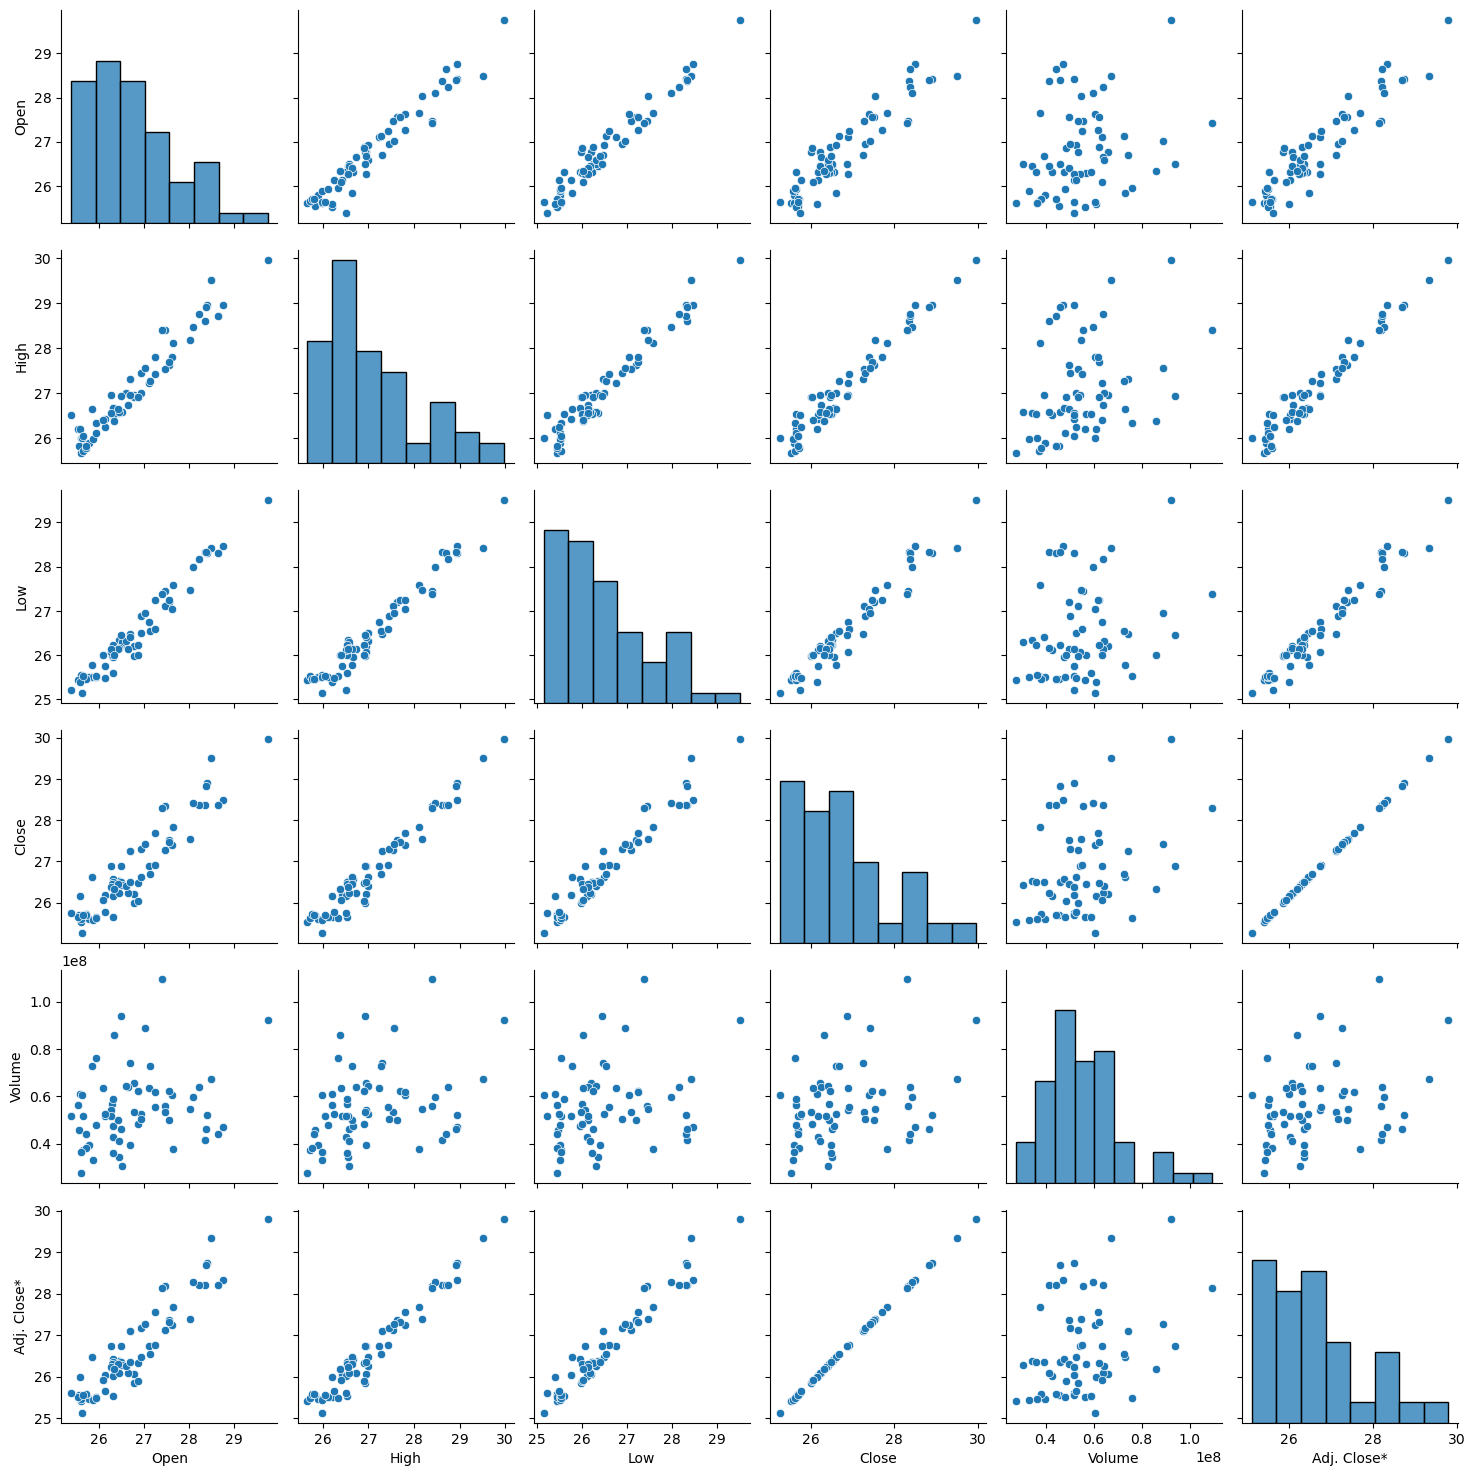

In [18]:
sns.pairplot(df)

<Axes: ylabel='Low'>

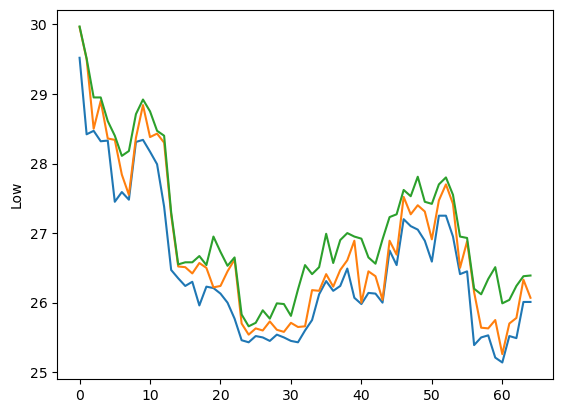

In [19]:
sns.lineplot(df['Low'])
sns.lineplot(df['Close'])
sns.lineplot(df['High'])

In [20]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\abhin\AppData\Local\Temp\ipykernel_15872\3492330880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [21]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [22]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [23]:
from torch.nn import LSTM, Sequential
import torch.nn as nn

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [25]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

In [26]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)